In [1]:
# Brain Tumor Recognition

# Vorgehen
1. Data preprocessing
2. Convulutional NN aufbauen
3. CNN trainieren
4. Analysieren
5. Falls möglich: Dense Network anhängen

# Data Preprocessing

In [3]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importieren der benötigten Bibliotheken
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
import random

In [5]:
# Seed setzen für Reproduzierbarkeit
seed = 42
# Für Tenserflow
tf.random.set_seed(seed)
# Für Numpy
np.random.seed(seed)
# Für Random
random.seed(seed)

In [6]:
# Laden der Daten
base_dir = os.path.join(os.getcwd(), "Daten")
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Parameter für die Datenverarbeitung
# Batch size
batch_size = 64
# Vereinheitlichung der Bildgrössen
img_height = 224
img_width = 224

# Training-Datensatz laden, erkennt die Labels anhand der Ordnerbeschriftungen
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),  # Bilder auf einheitliche Größe skalieren
    batch_size=batch_size,
    seed=seed
)

# Test-Datensatz laden, erkennt die Labels anhand der Ordnerbeschriftungen
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Überprüfung der geladenen Daten
print("Trainingsdatenklassen:", train_ds.class_names)
print("Testdatenklassen:", test_ds.class_names)

Found 3421 files belonging to 2 classes.


2025-01-02 21:38:03.844997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:88:00.0, compute capability: 8.6


Found 1310 files belonging to 2 classes.
Trainingsdatenklassen: ['No_Tumor', 'Tumor']
Testdatenklassen: ['No_Tumor', 'Tumor']


In [7]:
# Funktion, um die Anzahl der Bilder pro Klasse zu zählen
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Nur Ordner (Klassen) berücksichtigen
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    return class_counts

# Zähle Bilder im Trainings- und Testordner
train_class_counts = count_images_per_class(train_dir)
test_class_counts = count_images_per_class(test_dir)

# Ausgabe der Ergebnisse
print("Anzahl der Bilder pro Klasse (Training):")
for class_name, count in train_class_counts.items():
    print(f"  {class_name}: {count}")

print("\nAnzahl der Bilder pro Klasse (Testing):")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")


Anzahl der Bilder pro Klasse (Training):
  Tumor: 2071
  No_Tumor: 1350

Anzahl der Bilder pro Klasse (Testing):
  Tumor: 905
  No_Tumor: 405


Die beiden Klassen Tumor und No_Tumor haben in den Test- respektive Trainingsdaten unterschiedlich viele Anzahl Bilder. Dies könnte später zu einem Bias im Modell führen, da das Modell mehr Bilder mit Tumor sieht als ohne.

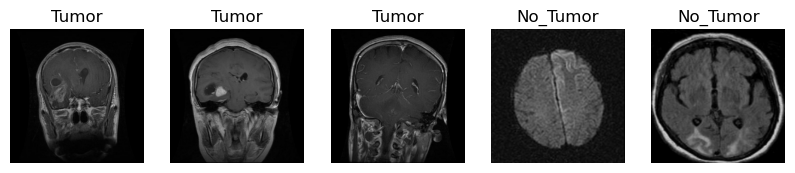

In [8]:
# Anzahl der Bilder, die angezeigt werden sollen
num_images = 5

# Hole eine kleine Stichprobe von Bildern und Labels
image_batch, label_batch = next(iter(train_ds))

# Anzeigen der Bilder und ihrer Klassen
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[label_batch[i].numpy()])
    plt.axis("off")

plt.show()


Oben ist eine zufällige Auswahl von 5 Bildern im Testdatensatz ersichtlich. Bei mehrmaligem Ausführen werden stets neue (andere) Bilder angezeigt. Dies soll helfen, besser zu verstehen, wie die MRI-Bilder aussehen und wo es Probleme geben könnte. Auffällig ist natürlich, dass die MRI-Bilder verschiedene Perspektiven haben (seitlich, von oben, von vorne etc.), was evtl. ein Problem für das Modell sein könnte.

In [9]:
# Modell erstellen
model = models.Sequential([
    # Rescaling Layer: Skaliert die Pixelwerte der Eingabebilder (von 0-255 auf 0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # Erstes Convolutional Layer: Fährt mit einer 2D-Faltung, um Merkmale aus den Bildern zu extrahieren
    layers.Conv2D(32, (5, 5), activation='relu'), # 32 Filter, Kernelgröße 5x5, ReLU-Aktivierungsfunktion
    # Max-Pooling Layer: Reduziert die Bildgröße (downsizing) und extrahiert die wichtigsten Merkmale
    layers.MaxPooling2D((2, 2)), # Pooling-Größe von 2x2, reduziert die Dimensionen
    # Dropout Layer: Verhindert Overfitting, indem während des Trainings zufällig ein Prozentsatz der Neuronen deaktiviert wird
    layers.Dropout(0.2), # 20% der Neuronen werden während des Trainings deaktiviert
    
    # Zweites Convolutional Layer mit Max-Pooling und Dropout
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Drittes Convolutional Layer mit Max-Pooling und Dropout
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Flatten
    layers.Flatten(),
    # Erster Dense-Layer mit 256 Neuronen und ReLu als acrivation function
    layers.Dense(256, activation='relu'),
    # Zweiter Dense-Layer mit 128 Neuronen und ReLu als acrivation function
    layers.Dense(128, activation='relu'),
    # Dropout Layer
    layers.Dropout(0.2),
    # Dritter Dense Layer mit 2 Neuronen und softmax (weil Klassifizierungstask) als activation function
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Anzahl der Klassen (Tumor/No_Tumor)
])

# Modell zusammenfassen
model.summary()

# EarlyStopping Callback definieren
early_stopping = EarlyStopping(monitor='val_accuracy',  # Überwachen des Validation Loss
                               patience=15,         # Geduld (wie viele Epochen ohne Verbesserung)
                               restore_best_weights=True)  # Bestes Modell wird zurückgegeben

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), #Adam optimizer mit sehr tiefer learning
              loss='sparse_categorical_crossentropy', # Crossentropy als Lossfunktion
              metrics=['accuracy']) # Accuracy (Metrik) wird während dem Training überwacht

# Modell trainieren mit EarlyStopping Callback
history = model.fit(
    train_ds,
    epochs=40,  # Anzahl der Epochen
    validation_data=test_ds,
    callbacks=[early_stopping], # Callback hinzufügen (EarlyStopping)
    )

/opt/conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 49, 49, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,166,402 (73.11 MB)

 Trainable params: 19,166,402 (73.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


I0000 00:00:1735853890.492547   62950 service.cc:146] XLA service 0x7ef66c00e0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735853890.492599   62950 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2025-01-02 21:38:10.566392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-02 21:38:10.756412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-02 21:38:11.085166: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
20

53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6051 - loss: 0.6546

2025-01-02 21:38:49.682519: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2239', 8 bytes spill stores, 8 bytes spill loads

2025-01-02 21:38:49.875512: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2239', 24 bytes spill stores, 24 bytes spill loads

2025-01-02 21:38:58.722111: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,32,110,110]{3,2,1,0}, f32[29,64,106,106]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_s

54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 731ms/step - accuracy: 0.6081 - loss: 0.6531 - val_accuracy: 0.6244 - val_loss: 0.6530
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.8259 - loss: 0.4673 - val_accuracy: 0.7481 - val_loss: 0.5385
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.8769 - loss: 0.3312 - val_accuracy: 0.7496 - val_loss: 0.5303
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9031 - loss: 0.2756 - val_accuracy: 0.7618 - val_loss: 0.5100
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9330 - loss: 0.2219 - val_accuracy: 0.7565 - val_loss: 0.5459
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.9373 - loss: 0.1922 - val_accuracy: 0.7481 - val_loss: 0.5986
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.9371 - loss: 0.1846 - val_accuracy: 0.7664 - val_loss: 0.5361
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9529 - loss: 0.1602 - val_accuracy: 0.7573

Das Modell lernt rund 19 Millionen Parameter, wobei logischerweise der Grossteil der Parameter beim ersten Dense-Layer anfällt.

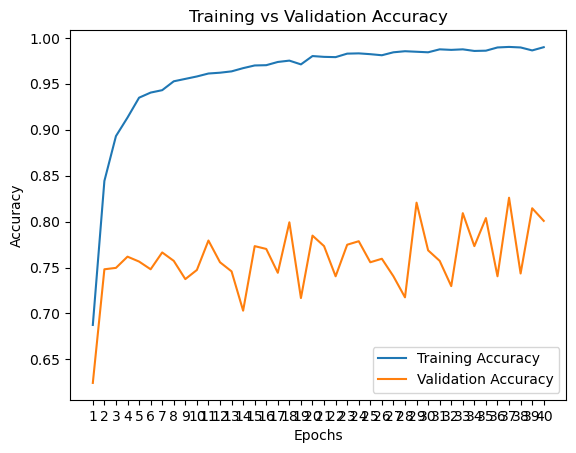

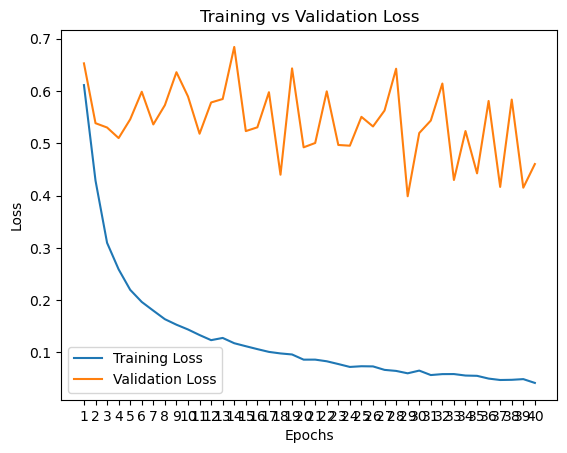

In [10]:
# Training und Validierung Accuracy plotten
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(len(history.history['accuracy'])), range(1, len(history.history['accuracy']) + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training und Validierung Loss plotten
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(len(history.history['accuracy'])), range(1, len(history.history['accuracy']) + 1))
plt.ylabel('Loss')
plt.legend()
plt.show()


2025-01-02 21:45:33.927443: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step


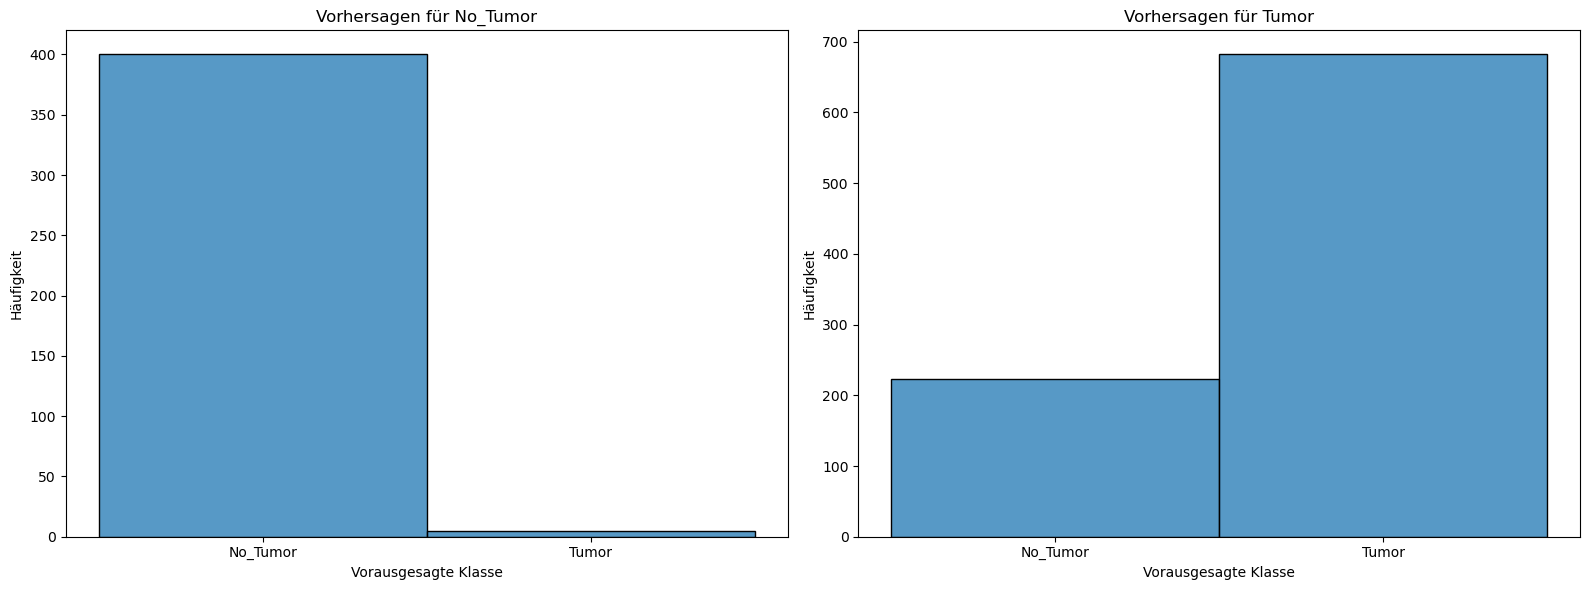

In [11]:
# Vorbereitung der Testdaten für Vorhersagen
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

# Vorhersagen machen
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# DataFrame mit wahren Labels und vorhergesagten Labels für Visualisierung
results_df = pd.DataFrame({
    'True Label': test_labels.numpy(),
    'Predicted Label': predicted_labels
})

# Visualisierung der Häufigkeit der Vorhersagen für jedes wahre Label
plt.figure(figsize=(16, 6))
for i in range(len(train_ds.class_names)):  # Wir haben 2 Klassen: 'Tumor' und 'No_Tumor'
    plt.subplot(1, 2, i + 1)  # 1 Reihe, 2 Spalten (da wir 2 Klassen haben)
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(3) - 0.5, kde=False)
    plt.title(f'Vorhersagen für {train_ds.class_names[i]}')
    plt.xlabel('Vorausgesagte Klasse')
    plt.ylabel('Häufigkeit')
    plt.xticks([0, 1], labels=train_ds.class_names)

plt.tight_layout()
plt.show()


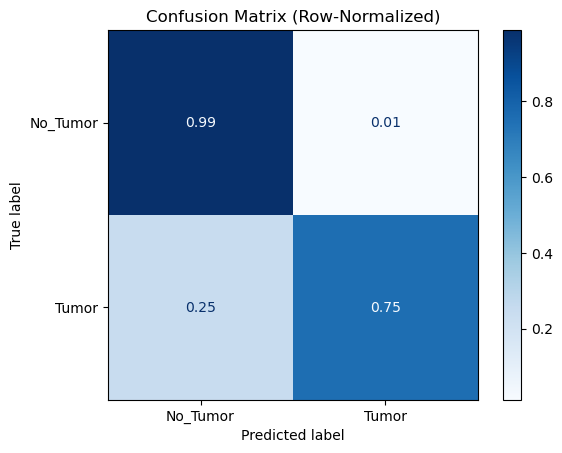

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Wahre Labels und vorhergesagte Labels aus results_df extrahieren
true_labels = results_df['True Label']
predicted_labels = results_df['Predicted Label']

# Confusion Matrix berechnen
cm = confusion_matrix(true_labels, predicted_labels)

# Skalierung der Farbskala pro Zeile
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Confusion Matrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=train_ds.class_names)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')  # Werte in der Matrix mit 2 Dezimalstellen anzeigen
plt.title('Confusion Matrix (Row-Normalized)')
plt.show()